# Transformers for Auto-Regressive Modeling on MNIST

This notebook explores how Transformers can be used in **auto-regressive sequence modeling**, using the MNIST dataset.

Auto-regression means predicting the next element conditioned on all previous ones.

---

## Why auto-regression?

Given ordered sequence $x_1, x_2, \dots, x_T$, we model:

$$p(x_1, x_2, \dots, x_T) = \prod_{t=1}^T p(x_t \mid x_{<t}).$$

This factorization implies that sequence generation is performed step-by-step, predicting the next token conditioned on all previous tokens.

---

## MNIST Framing

MNIST images are reshaped from $28 \times 28$ into a **sequence of 784 pixels**.

- Pixel intensities are normalized to $[0,1]$.
- Each pixel $x_t$ depends on previous pixels $x_{<t}$.

We learn a model:

$$p(x_t \mid x_{1:t-1}).$$

---

## Transformer Auto-Regressive formulation

Let $X \in \mathbb{R}^{T \times d}$ be input token embeddings.

For each layer, attention computes:

$$\text{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d}}\right)V.$$

Causal masking ensures:

$$a_{ij} = 0 \quad \text{if}\ j > i.$$

---

## Training Objective (Negative Log-Likelihood)

$$\mathcal{L} = -\sum_{t=1}^{T} \log p_\theta(x_t \mid x_{<t}).$$

During **sampling/inference**, tokens are generated sequentially.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 515kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.25MB/s]


## Auto-regressive Transformer Architecture

### Tokenization

We reshape MNIST image:

$$x \in \mathbb{R}^{1 \times 28 \times 28} \Rightarrow x \in \mathbb{R}^{784}$$

Each pixel value is treated as a token.

### Embedding Layer

Pixel scalars $x_t$ are embedded into $d$-dim feature space:

$$e_t = W x_t.$$

### Positional Encoding

Transformer requires order:

$$p_t = f(t).$$

### Causal Mask

Transformers forbid looking at future tokens:

$$a_{ij} = 0,\ j > i.$$

### Output Prediction

Predict each pixel value:

$$\hat{x}_t = \sigma(W_o h_t).$$


In [2]:
class PixelTransformer(nn.Module):
    def __init__(self, seq_len=784, d_model=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embed = nn.Linear(1, d_model)
        self.pos_embedding = nn.Embedding(seq_len, d_model)

        self.layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model,
                                       nhead=num_heads,
                                       dim_feedforward=128,
                                       activation='gelu',
                                       batch_first=True),
            num_layers=num_layers
        )

        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        batch, seq = x.shape
        pos = torch.arange(seq, device=x.device).unsqueeze(0).repeat(batch, 1)

        x = x.unsqueeze(-1)
        x = self.embed(x) + self.pos_embedding(pos)

        attn_mask = torch.triu(torch.ones(seq, seq), diagonal=1).bool().to(x.device)

        out = self.layers(x, mask=attn_mask)
        return torch.sigmoid(self.output(out))


model = PixelTransformer().to(device)
print(model)


PixelTransformer(
  (embed): Linear(in_features=1, out_features=64, bias=True)
  (pos_embedding): Embedding(784, 64)
  (layers): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [3]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10  # set 50 if you want full run
loss_log = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img, _ in train_loader:
        img = img.view(img.size(0), -1).to(device)  # (B, 784)

        pred = model(img)

        loss = F.mse_loss(pred.squeeze(), img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_log.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.5f}")


Epoch 1 Loss: 0.00482
Epoch 2 Loss: 0.00012
Epoch 3 Loss: 0.00006
Epoch 4 Loss: 0.00004
Epoch 5 Loss: 0.00003
Epoch 6 Loss: 0.00002
Epoch 7 Loss: 0.00002
Epoch 8 Loss: 0.00001
Epoch 9 Loss: 0.00001
Epoch 10 Loss: 0.00001


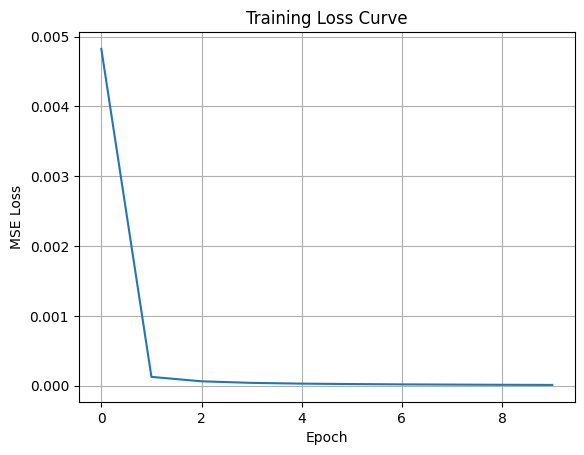

In [4]:
plt.plot(loss_log)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()


## Visualizing Attention Maps

We inspect a trained model's attention behavior:

1. Extract encoder attention weights
2. Show as heatmap illustrating:
   - token vs token influence


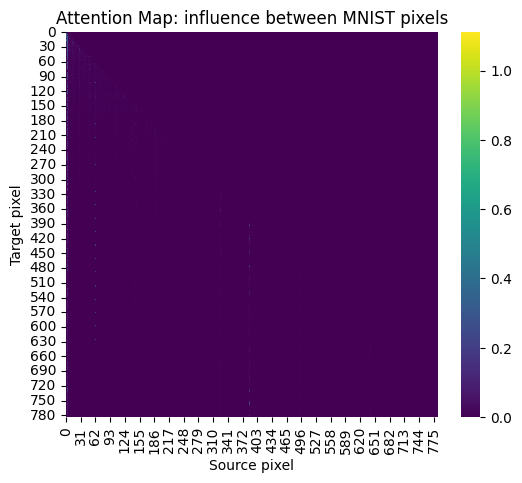

In [5]:
# Select one example batch
sample, _ = next(iter(train_loader))
sample = sample.view(sample.size(0), -1).to(device)[:1]

with torch.no_grad():
    batch, seq_len = sample.shape
    pos = torch.arange(seq_len).unsqueeze(0).to(device)
    x = model.embed(sample.unsqueeze(-1)) + model.pos_embedding(pos)

    attn_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(device)

    layer = model.layers.layers[0]
    attn_output, attn_weights = layer.self_attn(
        x, x, x, attn_mask=attn_mask, need_weights=True
    )

attn = attn_weights.squeeze().cpu().numpy()

plt.figure(figsize=(6,5))
sns.heatmap(attn, cmap="viridis")
plt.title("Attention Map: influence between MNIST pixels")
plt.xlabel("Source pixel")
plt.ylabel("Target pixel")
plt.show()


## PCA Visualization of Feature Embeddings

We analyze how Transformer restructures pixel space by projecting hidden representations to:

- 2D PCA plane
- 3D PCA space


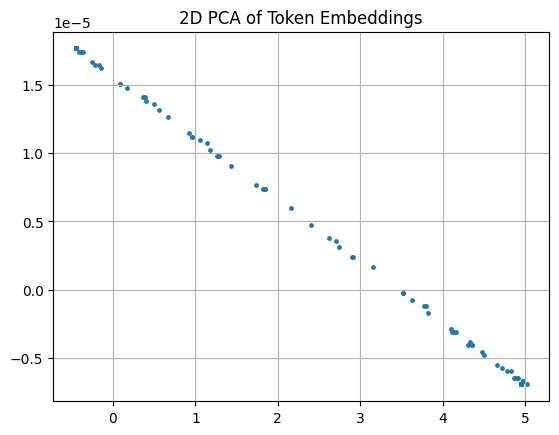

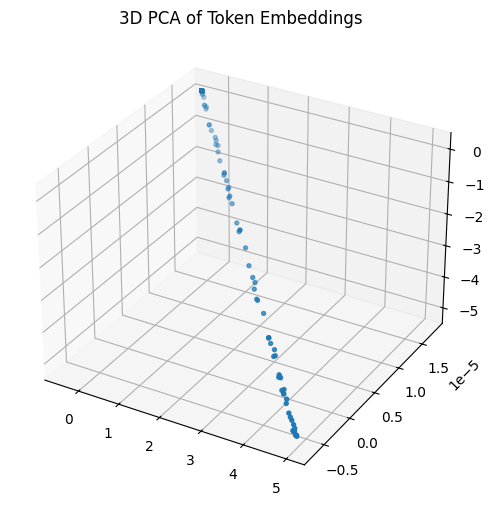

In [6]:
with torch.no_grad():
    rep = model.embed(sample.unsqueeze(-1)).squeeze().cpu().numpy()

pca = PCA(n_components=2)
rep2 = pca.fit_transform(rep)

plt.scatter(rep2[:,0], rep2[:,1], s=6)
plt.title("2D PCA of Token Embeddings")
plt.grid()
plt.show()

pca3 = PCA(n_components=3)
rep3 = pca3.fit_transform(rep)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rep3[:,0], rep3[:,1], rep3[:,2], s=8)
ax.set_title("3D PCA of Token Embeddings")
plt.show()


## Auto-Regressive Sampling

Given a trained MNIST transformer, we generate an image pixel-by-pixel:

$$\hat{x}_t = p_\theta(x_t \mid x_{<t}).$$


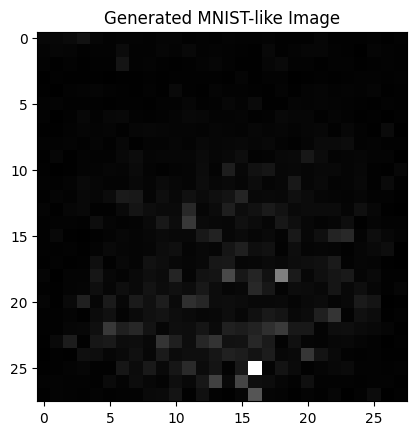

In [7]:
def autoregressive_generate(model):
    model.eval()
    seq = torch.zeros(1, 784, device=device)

    for t in range(784):
        with torch.no_grad():
            pred = model(seq)
        seq[0, t] = pred[0, t]
    return seq.reshape(28, 28).cpu().numpy()

generated = autoregressive_generate(model)

plt.imshow(generated, cmap="gray")
plt.title("Generated MNIST-like Image")
plt.show()


# Summary and Use-Cases

### What we learned

1. A Transformer can model MNIST pixels auto-regressively.
2. Attention determines how earlier pixels influence later predictions.
3. PCA projections and heatmaps help visualize structure building.

### Real world applications

- Text generation (GPT)
- Image autoregressive models (Pixel Transformer)
- Music generation
- Sequential sensor forecasting
